In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#How to add the file to gdrive

1. Open the drive link shared
2. Click the three dots next to ***HV-AI-2024*** and select 'Make a copy'

In [3]:
!cp /content/drive/MyDrive/HV-AI-2024.zip /content/HV-AI-2024.zip
!unzip HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm /content/HV-AI-2024.zip
!rm -rf /content/sample_data
from google.colab import output
output.clear()

# **Plot Sample Images**

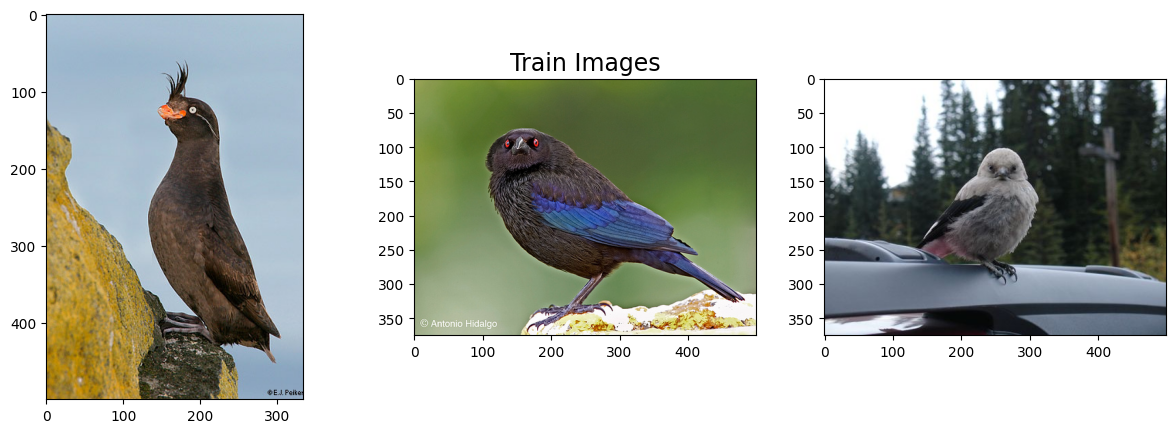

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob

train_images = glob('images/train/*.jpg')[15:18]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

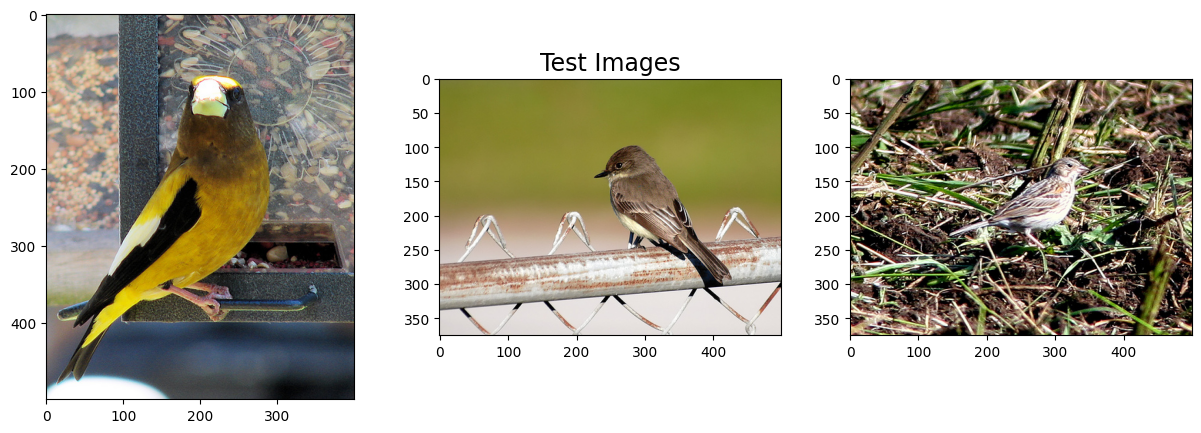

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

Importing necessary libraries

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# **Load/Preprocess **data****

Checking for class imbalance. Each of the class has approx 30 images and thus we have balanced data.

In [7]:
df = pd.read_csv('train.csv')
class_counts = df['class'].value_counts()

print("Summary of class distribution:")
print(f"Min samples in a class:   {class_counts.min()}")
print(f"Max samples in a class:   {class_counts.max()}")
print(f"Mean samples per class:   {class_counts.mean()}")
print(f"Std deviation:            {class_counts.std()}")

Summary of class distribution:
Min samples in a class:   29
Max samples in a class:   30
Mean samples per class:   29.97
Std deviation:            0.17101529509309654


Splitting the data into train and validation dataframes also ensuring class balance in both.

In [8]:
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df['class'],
    random_state = 9
)

Dataset class for loading and preprocessing data

In [9]:
class BirdDataset(Dataset):
  def __init__(self, data_frame, transform=None):
    self.labels = data_frame
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    img_path = self.labels.iloc[index, 0]
    image = Image.open(img_path).convert('RGB')

    # cropping image to include only the bird
    bbox_values = list(map(lambda x: int(float(x)), train_df['bbox'][0].split(" ")))
    cropped_image = image.crop((bbox_values[0], bbox_values[1], bbox_values[0]+bbox_values[2], bbox_values[1]+bbox_values[3]))

    label = self.labels.iloc[index, 1]
    if self.transform:
      cropped_image = self.transform(cropped_image)
    return cropped_image, label

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = BirdDataset(train_df, transform=transform)
val_dataset = BirdDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [12]:
# checking
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Model initialization/Training**

Below are three model, ResNet18, ResNet50 and a custom model. Uncomment the cell based on the model you want to use.

### ResNet-18

In [14]:
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(512, 200)

### ResNet-50

In [32]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 200)

### Custom Model

In [21]:
# class Model(nn.Module):
#     def __init__(self, num_classes=200):
#         super(Model, self).__init__()

#         self.features = nn.Sequential(
#             # block 1
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32),  # depthwise conv
#             nn.Conv2d(32, 64, kernel_size=1),  # pointwise
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),

#             # block 2
#             nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64),
#             nn.Conv2d(64, 128, kernel_size=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),

#             # block 3
#             nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
#             nn.Conv2d(128, 256, kernel_size=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.AdaptiveAvgPool2d(1)
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x
# model = Model()

In [ ]:
# def init_weights_kaiming(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)
#     elif isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.ones_(m.weight)
#         nn.init.zeros_(m.bias)

# model.apply(init_weights_kaiming)

In [33]:
model = model.to(device)

num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")

Number of parameters: 23917832


Setting hyperparameters

In [34]:
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)
scheduler = scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, min_lr=1e-4, verbose=True)

Training Loop

In [35]:
train_log_path = "train_log.csv"
test_log_path = "test_log.csv"

def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0
    correct = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = correct / size
    avg_loss = total_loss / len(dataloader)

    print(f"Epoch {epoch+1}: Train Loss: {avg_loss:.6f}, Accuracy: {100*accuracy:.2f}%")

    with open(train_log_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, round(100 * accuracy, 2), round(avg_loss, 6)])


global best_accuracy
best_accuracy = 0.0

def test_loop(dataloader, model, loss_fn, epoch):
    global best_accuracy
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    scheduler.step(accuracy)

    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print(f" Saved better model (epoch {epoch+1}) with accuracy: {100*accuracy:.2f}%")

    # Log to CSV
    with open(test_log_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, round(100 * accuracy, 2), round(test_loss, 6)])

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, t)
    test_loop(val_loader, model, loss_fn, t)
print("Done!")

# **Model Inference**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 200)  # 200 = number of classes
model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))

model = model.to(device)
model.eval()

test_dir = "/content/images/test"
image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

csv_filename = "pred.csv"

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['path', 'predicted_label', 'confidence_score'])

    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)

            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted_class = torch.max(probabilities, dim=1)

            rel_path = os.path.relpath(image_path, start="/content")
            writer.writerow([rel_path, predicted_class.item(), confidence.item()])

print(f"Predictions saved to {csv_filename}")

# **Helper Functions**

In [39]:
import requests

def send_results_for_evaluation(name, csv_file, email, offcampus):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name, 'offcampus':offcampus}
    response = requests.post(url, files=files, data=data)
    return response.json()

# ***Test Inference***


This function is used to save the csv file and send it to the evaluation server.

Format of CSV file (Follow the header names strictly):

        path (str)              predicted_label(int)   confidence_score(float)
    images/test/xx.jpg                  1                         0.6
    images/test/yy.jpg                  2                         0.9
            :                           :                          :
            :                           :                          :

Once the prediction file is saved as shown in the above format, you can send it to the evaluation server along with your email.

Caution: check your **email** before executing the cell.


In [40]:
print('Accuracy: ')
print(send_results_for_evaluation('Mantha Sai Gopal', '/content/pred.csv', 'manthasaigopal@gmail.com', 'offcampus'))

Accuracy: 
{'overall_accuracy (%)': 76.13048, 'max_accuracy_class': 133, 'max_accuracy (%)': 100.0, 'min_accuracy_class': 101, 'min_accuracy (%)': 16.66667}
